<h1 style="font-family: Georgia; font-size:3em;color:#2462C0; font-style:bold">
Bandit Algorithms: epsilon-Greedy Algorithm</h1>

A/B testing can be defined as a randomized controlled experiment that allows us to test if there is a causal relationship between a change to a website/app and the user behavior. The change can be visible such as location of a button on the homepage or invisible such as the ranking/recommendation algorithms and backend infrastructure.

Web/Mobile developers and business stakeholders always face the following dilemma: Should we try out all ideas and explore all options continuously? Or should we exploit the best available option and stick to it?
The answer is, as in most cases, will be a trade-off between the two extremes. If we explore all the time, we'll collect a lot of data and waste resources in testing inferior ideas and missing sales (e-commerce case). However, if we only exploit the available option and never try new ideas, we would be left behind and loose in the long-term with ever-changing markets.

In this series, we'll explore solutions offered by **Multi-armed Bandit Algorithms** that have two main advantages over traditional A/B testing:
- Smoothly decrease exploration over time instead of sudden jumps.
- Focus resources on better options and not keep evaluating inferior options during the life of the experiment.

What is **Bandit Algorithms**? Bandit Algorithms are algorithms that try to learn a rule of selecting a sequence of options that balance exploring available options and getting enough knowledge about each option and maximize profits by selecting the best option. Note that during the experiment, we only have knowledge about the options we tried. Therefore, every time we select an option that's not the best one, we incur an opportunity cost of not selecting the best option; however, we also gain a new knowledge (feedback) about the selected option. In other words, we need to have enough feedback about each option to learn the best option. As a result, the best strategy would be to explore more at the beginning of the experiment until we know the best option and then start exploiting that option.

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
epsilon-Greedy Algorithm</h2><br>
In this notebook, we'll cover **epsilon-Greedy Algorithm**. Greedy Algorithm can be defined as the algorithm that picks the best currently available option without taking into consideration the long-term effect of that decision, which may happen to be a suboptimal decision. Given that, we can define epsilon-Greedy Algorithm as a Greedy Algorithm that adds some randomness when deciding between options: Instead of picking always the best available option, randomly explore other options with a probability = $\epsilon$ or pick the best option with a probability = $1 - \epsilon$. Therefore, we can add randomness to the algorithm by increasing $\epsilon$, which will make the algorithm explores other options more frequently. Additionally, $\epsilon$ is a hyper-parameter that needs to be tuned based on the experiment, i.e. there is no value that works best on all experiments.
Let's explore how the algorithm works assuming we have two options: A and B (we can think of them as Control and Treatment groups). For each new user:
- Assume we have a coin that has a probability of coming heads = $\epsilon$ and a probability of coming tails = $1 - \epsilon$. Therefore,
    - If it comes heads, explore randomly the available options (exploration).
        - The probability of selecting any option is $\frac{1}{2}$.
    - If it comes tails, select the best option (exploitation).
    
As a result, the probability of selecting any option randomly if we have $N$ options is $\epsilon \frac{1}{N}$; however, the probability of selecting the best option is $1 - \epsilon$ (see figure 1).

<p align="center">
<img src="posts_images/bandit_algorithms/epsilon_greedy.PNG" style="height: 400px; width: 800px">
<caption><center><u><b><font color="purple">Figure 1:</font></b></u> epsilon-Greedy Algorithm</center></caption>
</p>

Let's import the needed packages and implement the algorithm.

In [1]:
# Import packages
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Add module path to system path
sys.path.append(os.path.abspath("../"))
from utils import plot_algorithm, compare_algorithms

%matplotlib inline
plt.style.use("fivethirtyeight")
sns.set_context("notebook")

In [2]:
class EpsilonGreedy:
    def __init__(self, epsilon, counts=None, values=None):
        self.epsilon = epsilon
        self.counts = counts
        self.values = values

    def initialize(self, n_arms):
        self.counts = np.zeros(n_arms, dtype=int)
        self.values = np.zeros(n_arms, dtype=float)

    def select_arm(self):
        z = np.random.random()
        if z > self.epsilon:
            # Pick the best arm
            return np.argmax(self.values)
        # Randomly pick any arm with prob 1 / len(self.counts)
        return np.random.randint(0, len(self.values))

    def update(self, chosen_arm, reward):
        # Increment chosen arm's count by one
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]

        # Recompute the estimated value of chosen arm using new reward
        value = self.values[chosen_arm]
        new_value = value * ((n - 1) / n) + reward / n
        self.values[chosen_arm] = new_value

Few things to note from the above implementation:
- Initialization of values (rewards) affect the long term performance of the algorithm.
- The larger the sample size (N), the less influential the rewards from the recent options since we are using the average of each option in the values array.
- Values array will store the estimated values (average) of each option.
- Counts is just an internal counter that keeps track of the number of times we selected each option.

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Monte Carlo Simulations</h2><br>
In order to evaluate the algorithm, we will use Monte Carlo simulations. We'll use 5000 simulations to overcome the randomness generated from the random number generator. Also, we'll use Bernoulli distribution to get the reward from each option on each run. For each simulation:
- Initialize the algorithm with no prior knowledge.
- Loop over the time horizon:
    - Select the option.
    - Draw the reward for the selected option using Bernoulli distribution and the probability defined.
    - Update the counts and estimated values of selected arm.

We'll define the % of reward (probability) of each option and test the performance of the algorithm using three different metrics:
- Probability of selecting the best option.
- Average rewards. This metric is a better approximation if the options are similar.
- Cumulative rewards. The previous two metrics are not fair metrics for algorithms with large epsilon where they sacrifice by exploring more options; however, cumulative rewards is what we should care about.

Moreover, we'll evaluate the algorithm using 5 different values of $\epsilon$: $0.1, 0.2, 0.3, 0.4, 0.5$. Since in the literature they use *arm* instead of *option* for historical reasons, we'll be using *arm* and *option* interchangeably.

In [3]:
class BernoulliArm:
    def __init__(self, p):
        self.p = p

    def draw(self):
        z = np.random.random()
        if z > self.p:
            return 0.0
        return 1.0


def test_algorithm(algo, arms, num_simulations, horizon):
    # Initialize rewards and chosen_arms with zero 2d arrays
    chosen_arms = np.zeros((num_simulations, horizon))
    rewards = np.zeros((num_simulations, horizon))

    # Loop over all simulations
    for sim in range(num_simulations):
        # Re-initialize algorithm's counts and values arrays
        algo.initialize(len(arms))

        # Loop over all time horizon
        for t in range(horizon):
            # Select arm
            chosen_arm = algo.select_arm()
            chosen_arms[sim, t] = chosen_arm

            # Draw from Bernoulli distribution to get rewards
            reward = arms[chosen_arm].draw()
            rewards[sim, t] = reward

            # Update the algorithms' count and estimated values
            algo.update(chosen_arm, reward)

    # Average rewards across all sims and compute cumulative rewards
    average_rewards = np.mean(rewards, axis=0)
    cumulative_rewards = np.cumsum(average_rewards)

    return chosen_arms, average_rewards, cumulative_rewards

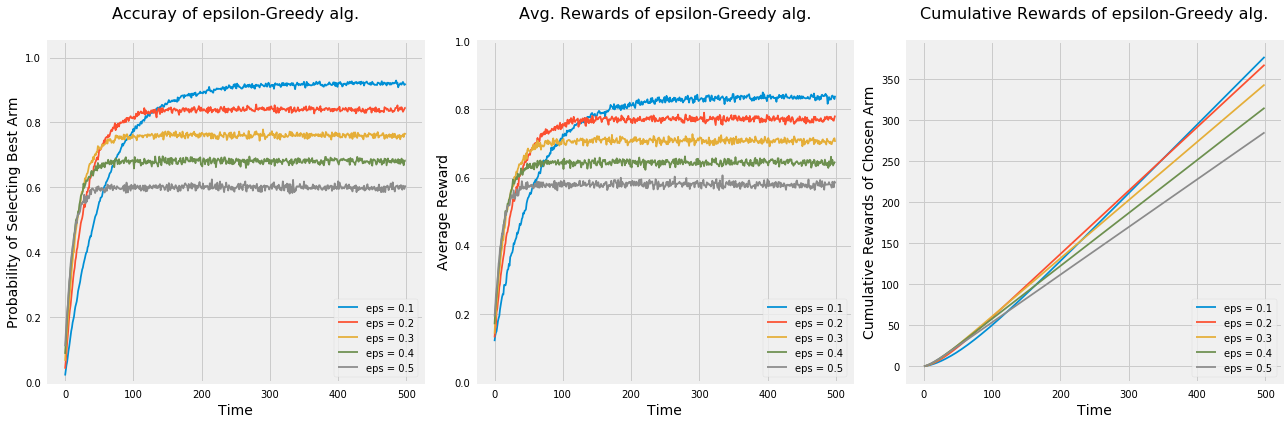

In [4]:
np.random.seed(1)
# Average reward by arm
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
# Shuffle the arms
np.random.shuffle(means)
# Each arm will follow and Bernoulli distribution
arms = list(map(lambda mu: BernoulliArm(mu), means))
# Get the index of the best arm to test if algorithm will be able to learn that
best_arm_index = np.argmax(means)
# Define epsilon value to check the performance of the algorithm using each one
epsilon = [0.1, 0.2, 0.3, 0.4, 0.5]

# Plot the epsilon-Greedy algorithm
plot_algorithm(alg_name="epsilon-Greedy", arms=arms, best_arm_index=best_arm_index,
               hyper_params=epsilon, num_simulations=5000, horizon=500, label="eps")

Few thing to note from the above graphs:
- Regardless of the epsilon values, all algorithms learned the best option.
- The algorithm picks options randomly; therefore, it's not guaranteed to always pick the best option even if it found that option. That's the main reason why none of the algorithms achieved a probability = 1 of selecting the best option or average rewards = % rewards of the best option even after they learned the best option.
- As $\epsilon$ increases $\rightarrow$ increase the exploration $\rightarrow$ increases the chance of picking options randomly instead of the best option.
- Algorithms with higher epsilon learn quicker but don't use that knowledge in exploiting the best option.
- Using accuracy in picking the best option and average rewards metrics, the algorithm $\epsilon = 0.1$ outperforms the rest; however, cumulative rewards metric shows that it takes that algorithm long time to outperform the algorithm with $\epsilon = 0.2$.
- Depends on time planned to run the experiment, different values of epsilons may be more optimal. For example, $\epsilon = 0.2$ is the best value for almost anything at or below 400.

Let's run the experiment again to see how would the algorithm behave under the following settings:
- Only two options.
- 50 options.
- 5 option that are very similar.

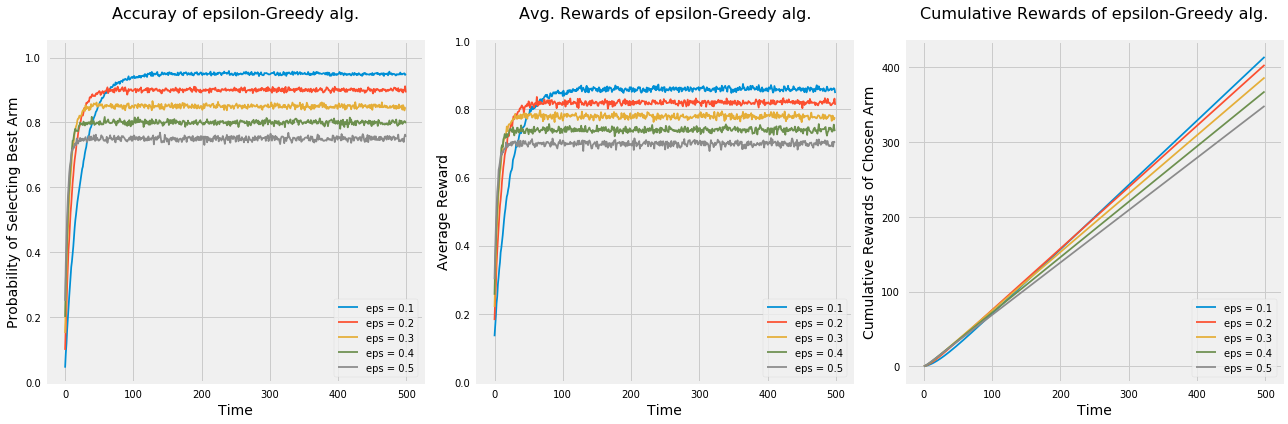

In [5]:
np.random.seed(1)
# Average reward by arm
means = [0.1, 0.9]
n_arms = len(means)
# Shuffle the arms
np.random.shuffle(means)
# Each arm will follow and Bernoulli distribution
arms = list(map(lambda mu: BernoulliArm(mu), means))
# Get the index of the best arm to test if algorithm will be able to learn that
best_arm_index = np.argmax(means)
# Define epsilon value to check the performance of the algorithm using each one
epsilon = [0.1, 0.2, 0.3, 0.4, 0.5]

# Plot the epsilon-Greedy algorithm
plot_algorithm(alg_name="epsilon-Greedy", arms=arms, best_arm_index=best_arm_index,
               hyper_params=epsilon, num_simulations=5000, horizon=500, label="eps")

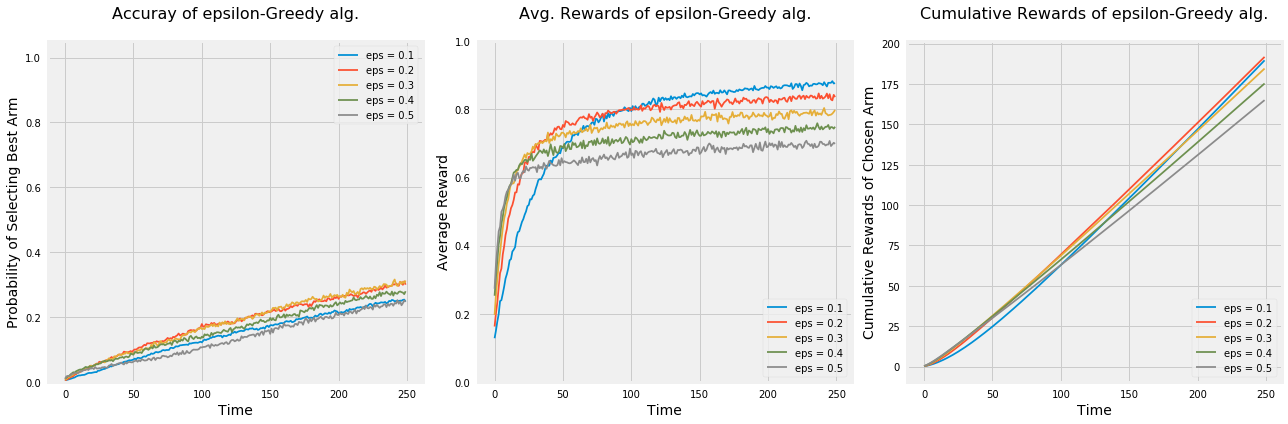

In [6]:
np.random.seed(1)
# Average reward by arm
means = [i for i in np.random.random(50)]
n_arms = len(means)
# Shuffle the arms
np.random.shuffle(means)
# Each arm will follow and Bernoulli distribution
arms = list(map(lambda mu: BernoulliArm(mu), means))
# Get the index of the best arm to test if algorithm will be able to learn that
best_arm_index = np.argmax(means)
# Define epsilon value to check the performance of the algorithm using each one
epsilon = [0.1, 0.2, 0.3, 0.4, 0.5]

# Plot the epsilon-Greedy algorithm
plot_algorithm(alg_name="epsilon-Greedy", arms=arms, best_arm_index=best_arm_index,
               hyper_params=epsilon, num_simulations=5000, horizon=250, label="eps")

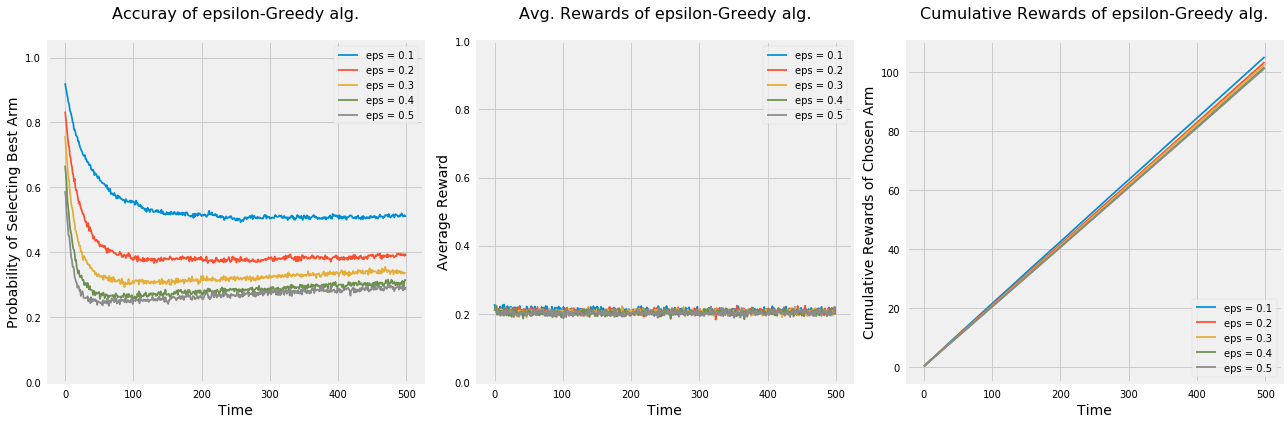

In [7]:
np.random.seed(1)
# Average reward by arm
means = [0.2, 0.18, 0.22, 0.19, 0.21]
n_arms = len(means)
# Shuffle the arms
np.random.shuffle(means)
# Each arm will follow and Bernoulli distribution
arms = list(map(lambda mu: BernoulliArm(mu), means))
# Get the index of the best arm to test if algorithm will be able to learn that
best_arm_index = np.argmax(means)
# Define epsilon value to check the performance of the algorithm using each one
epsilon = [0.1, 0.2, 0.3, 0.4, 0.5]

# Plot the epsilon-Greedy algorithm
plot_algorithm(alg_name="epsilon-Greedy", arms=arms, best_arm_index=best_arm_index,
               hyper_params=epsilon, num_simulations=5000, horizon=500, label="eps")

- When we had lower number of options, all algorithms were faster at learning the best option which can be seen by the steepness of all curves of the first two graphs when time < 100. As a result, all algorithms had higher cumulative rewards than when we had 5 options.
- Having large number of options made it hard on all algorithms to learn the best option and may need a lot more time to figure it out.
- Lastly, when options are very similar (in terms of rewards), the probability of selecting the best option by all algorithms decreases over time. Let's take the algorithm with $\epsilon = 0.1$ and see why is this the case. After some investigation, the algorithm was struggling in differentiating between the best option and the second best option since the difference between the % rewards is 1%. Therefore, the probability of selecting the best arm was around 50%.

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Annealed epsilon-Greedy Algorithm</h2><br>
Epsilon value plays a major role in the performance of epsilon-Greedy algorithm and has to be tuned to the best of our knowledge in terms of the expectations of the estimated rewards of each option. Nonetheless, this estimation suffers from high uncertainty since most of the times either we have no clue what might work or the results would be against our intuition as user experience research has shown in multiple studies. Therefore, isn't it nice if we can avoid setting up the epsilon values and make the algorithm parameter-free? That's what **Annealed epsilon-Greedy Algorithm** does. We specify the rule of decaying epsilon with time and let the algorithm runs with no hyper-parameter configurations. The rule of we will use here is: $\epsilon = \frac{1}{log(time + 0.0000001)}$. As we can see, at the beginning of the experiment, $\epsilon$ would be close to Inf and that means a lot of exploration; however, as time goes, $\epsilon$ start approaching zero and the algorithm would exploit more and more by selecting the best option.

We will evaluate the Annealed version using the same settings as before and compare it to standard version.

In [8]:
class AnnealingEpsilonGreedy(EpsilonGreedy):
    def __init__(self, counts=None, values=None):
        self.counts = counts
        self.values = values

    def select_arm(self):
        # Epsilon decay schedule
        t = np.sum(self.counts) + 1
        epsilon = 1 / np.log(t + 0.0000001)

        z = np.random.random()
        if z > epsilon:
            # Pick the best arm
            return np.argmax(self.values)
        # Randomly pick any arm with prob 1 / len(self.counts)
        return np.random.randint(0, len(self.values))

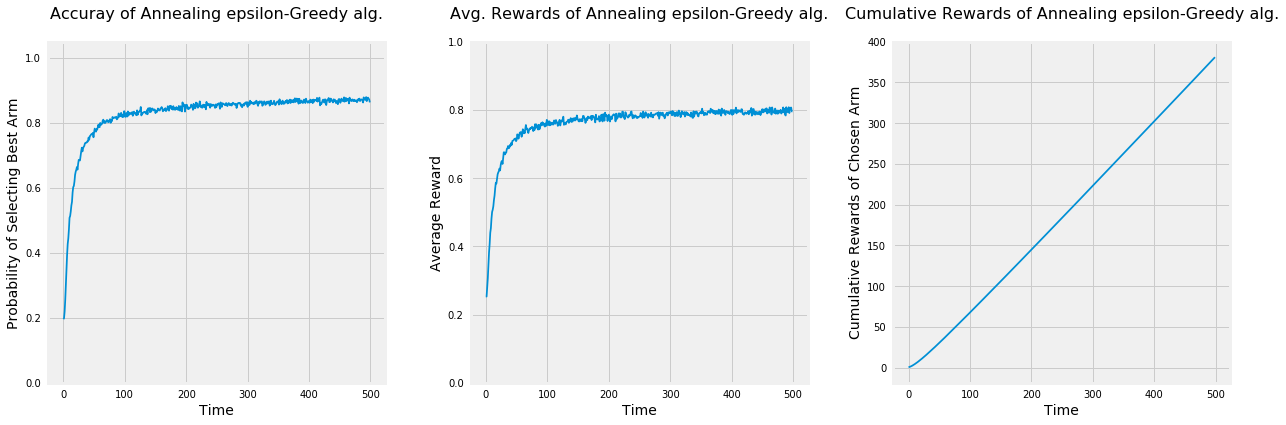

In [9]:
np.random.seed(1)
# Average reward by arm
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
# Shuffle the arms
np.random.shuffle(means)
# Each arm will follow and Bernoulli distribution
arms = list(map(lambda mu: BernoulliArm(mu), means))
# Get the index of the best arm to test if algorithm will be able to learn that
best_arm_index = np.argmax(means)

# Plot the epsilon-Greedy algorithm
plot_algorithm(alg_name="Annealing epsilon-Greedy", arms=arms, best_arm_index=best_arm_index,
               num_simulations=5000, horizon=500)

Even though the accuracy of selecting the best option and the average rewards of the annealing epsilon-Greedy Algorithm is lower than the standard version, it has higher cumulative rewards. Also, since the real world is uncertain and we may not have any clue about the designed options, it may be preferred to use the annealing version under some scenarios.

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold\">
Conclusion</h2><br>
epsilon-Greedy Algorithm works by going back and forth between exploration with probability = $\epsilon$ and exploitation with probability $1 - \epsilon$. Below are some takeaways:
- Setting the value of epsilon:
    - If we set $\epsilon = 1$, we would only explore the available options with a probability = $\frac{1}{N}$ of selecting any option. This will enable us to explore a lot of ideas at the expense of wasting resources by evaluating inferior options.
    - If we set $\epsilon = 0$, we would exploit the best option and never explore any new idea. This strategy would leave up behind our competitors given that the markets are so volatile.
- Exploration should be high at the beginning of the experiment to gain the knowledge about all the available options. It should decrease as a function of time where at some point after having enough data about all options, the algorithm should focus on exploiting the best option.
- All algorithms with different epsilon values learned the best option; however, they differ by the level of randomness of each algorithm in keep randomly exploring available options.
- To get the best results of any Bandit algorithm, we should have a lot of data, which means to run the experiment longer in most cases.
- For experiments that run for short period of time, traditional A/B testing may be better.
- Initialization of estimated rewards can affect the long-term performance of the algorithm. As a result, we may need to use previous experience and intuition to guide our initial values.